In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [36]:
# Load the dataset
data = pd.read_csv('aus_rainfall_by_district_2009_2017.csv')
# Display the first few rows of the dataset
data.head()

,Date,BadgerysCreek,Newcastle,NorahHead,Penrith,Richmond,Sydney,SydneyAirport,Williamtown,Wollongong
0,2009-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009-01-03,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.4,0.0
3,2009-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Extract Sydney City data and Date
sydney_data = data[['Date', 'Sydney']].copy()
# Convert 'Date' to datetime format
sydney_data['Date'] = pd.to_datetime(sydney_data['Date'])
# Set 'Date' as the index
sydney_data.set_index('Date', inplace=True)
# Sort the data by date
sydney_data.sort_index(inplace=True)
# Display the first few rows of the Sydney data
sydney_data.head()

,Sydney
Date,
2009-01-01,0.0
2009-01-02,0.0
2009-01-03,0.0
2009-01-04,0.0
2009-01-05,0.0


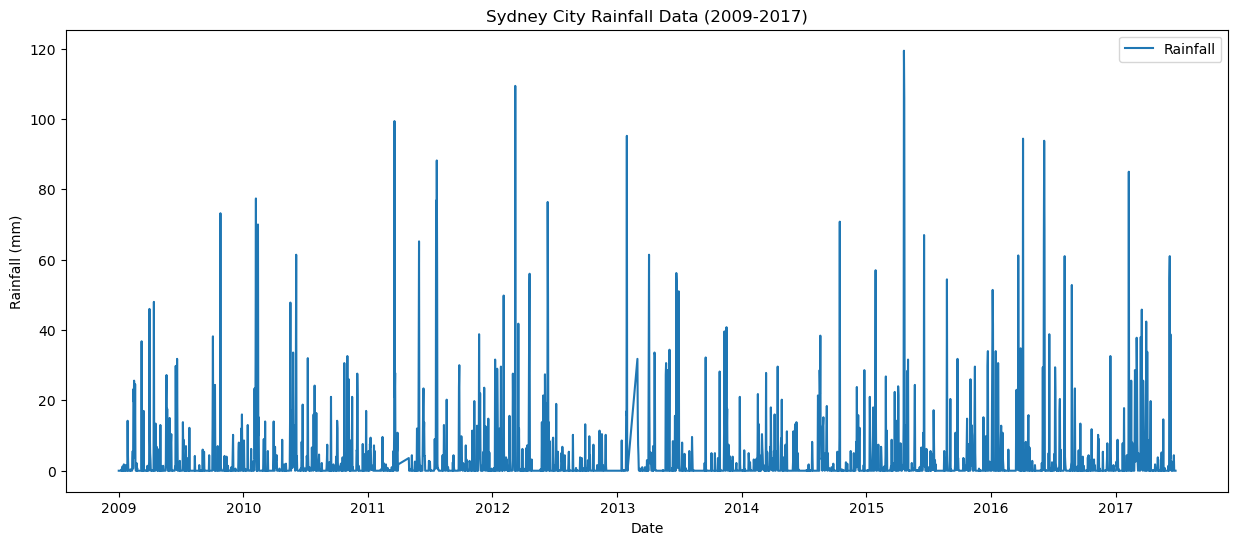

In [38]:
# Plotting the Sydney City rainfall data
plt.figure(figsize=(15, 6))
plt.plot(sydney_data.index, sydney_data['Sydney'], label='Rainfall')
plt.title('Sydney City Rainfall Data (2009-2017)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sydney_data)
# Creating training and testing datasets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]
# Function to create dataset with look_back days
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# Create training and testing data with look_back days
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Display the shape of training and testing data
trainX.shape, testX.shape

((2376, 1, 30), (571, 1, 30))

Epoch 1/50
75/75 - 2s - loss: 0.0063 - val_loss: 0.0092 - 2s/epoch - 32ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0060 - val_loss: 0.0091 - 152ms/epoch - 2ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0059 - val_loss: 0.0090 - 156ms/epoch - 2ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0058 - val_loss: 0.0090 - 158ms/epoch - 2ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0058 - val_loss: 0.0089 - 158ms/epoch - 2ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0058 - val_loss: 0.0089 - 160ms/epoch - 2ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0058 - val_loss: 0.0089 - 159ms/epoch - 2ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0058 - val_loss: 0.0089 - 176ms/epoch - 2ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0057 - val_loss: 0.0089 - 161ms/epoch - 2ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0057 - val_loss: 0.0089 - 172ms/epoch - 2ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0057 - val_loss: 0.0089 - 157ms/epoch - 2ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0057 - val_loss: 0.0089 - 179ms/epoch - 2ms/step
Epoch 13/50
75/75 - 0s - lo

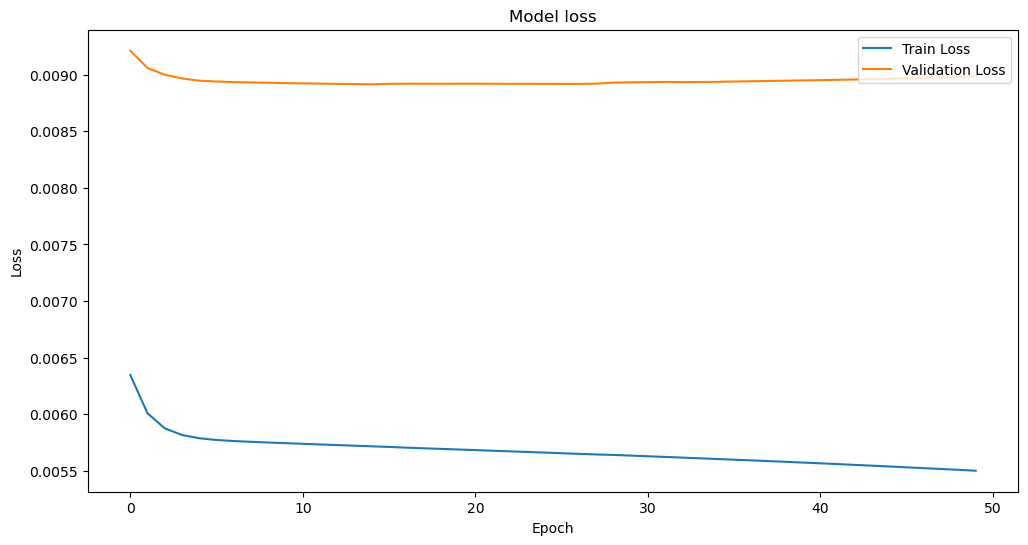

In [40]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), verbose=2, shuffle=False)
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

18/18 [==============================] - 0s 1ms/step


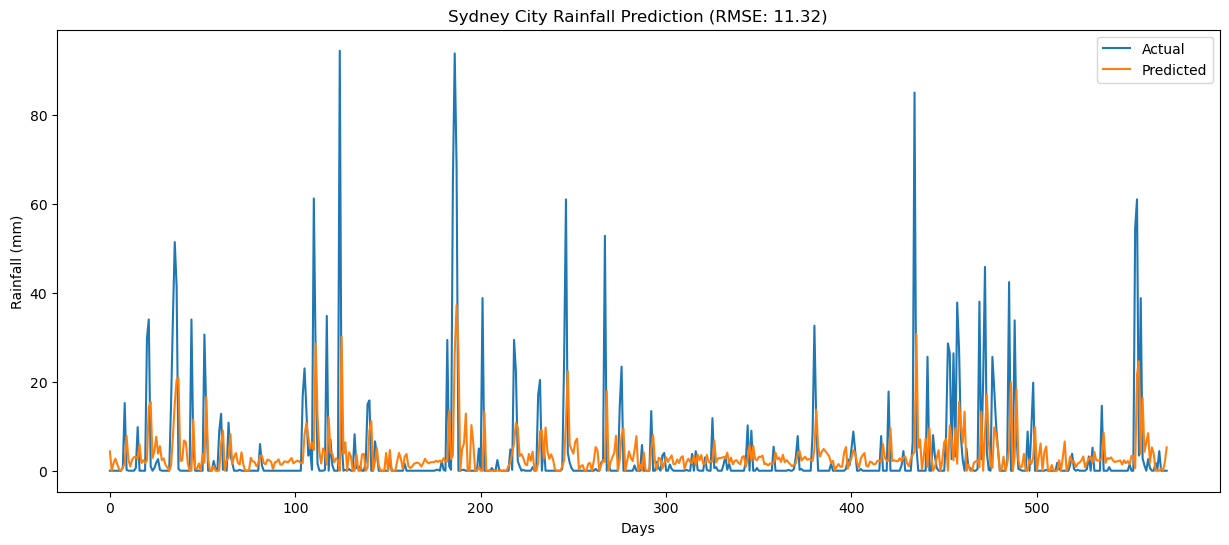

11.318371372944902

In [41]:
# Make predictions using the test data
test_predictions = model.predict(testX)
# Inverse transform the predictions to original scale
test_predictions = scaler.inverse_transform(test_predictions)
# Inverse transform the actual test data to original scale
testY_original = scaler.inverse_transform([testY])
# Calculate RMSE (Root Mean Squared Error)
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(testY_original[0], test_predictions[:, 0]))
# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(testY_original[0], label='Actual')
plt.plot(test_predictions[:, 0], label='Predicted')
plt.title(f'Sydney City Rainfall Prediction (RMSE: {rmse:.2f})')
plt.xlabel('Days')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()
# Display RMSE
rmse

In [42]:
data_reimported = pd.read_csv('aus_rainfall_by_district_2009_2017.csv')
# Display the first few rows of the re-imported dataset
data_reimported.head()

,Date,BadgerysCreek,Newcastle,NorahHead,Penrith,Richmond,Sydney,SydneyAirport,Williamtown,Wollongong
0,2009-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009-01-03,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.4,0.0
3,2009-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Extract data for Sydney and other districts
multi_var_data = data[['Sydney', 'BadgerysCreek', 'Newcastle', 'NorahHead', 'Penrith', 'Richmond', 'SydneyAirport', 'Williamtown', 'Wollongong']].copy()
# Convert 'Date' to datetime format and set it as the index
multi_var_data['Date'] = pd.to_datetime(data['Date'])
multi_var_data.set_index('Date', inplace=True)
# Sort the data by date
multi_var_data.sort_index(inplace=True)
# Display the first few rows of the multivariate data
multi_var_data.head()

,Sydney,BadgerysCreek,Newcastle,NorahHead,Penrith,Richmond,SydneyAirport,Williamtown,Wollongong
Date,,,,,,,,,
2009-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-03,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.4,0.0
2009-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Scaling the multivariate data
scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaled_multi_data = scaler_multi.fit_transform(multi_var_data)
# Creating training and testing datasets for multivariate analysis
train_size_multi = int(len(scaled_multi_data) * 0.8)
test_size_multi = len(scaled_multi_data) - train_size_multi
train_multi, test_multi = scaled_multi_data[0:train_size_multi, :], scaled_multi_data[train_size_multi:len(scaled_multi_data), :]
# Function to create dataset with look_back days for multivariate analysis
def create_multi_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# Create training and testing data with look_back days
look_back_multi = 30
trainX_multi, trainY_multi = create_multi_dataset(train_multi, look_back_multi)
testX_multi, testY_multi = create_multi_dataset(test_multi, look_back_multi)
# Reshape input to be [samples, time steps, features]
trainX_multi = np.reshape(trainX_multi, (trainX_multi.shape[0], 1, trainX_multi.shape[1] * trainX_multi.shape[2]))
testX_multi = np.reshape(testX_multi, (testX_multi.shape[0], 1, testX_multi.shape[1] * testX_multi.shape[2]))
# Display the shape of training and testing data for multivariate analysis
trainX_multi.shape, testX_multi.shape

((2376, 1, 240), (571, 1, 240))

Epoch 1/50
75/75 - 3s - loss: 0.0063 - val_loss: 0.0091 - 3s/epoch - 36ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0057 - val_loss: 0.0088 - 161ms/epoch - 2ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0056 - val_loss: 0.0087 - 163ms/epoch - 2ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0054 - val_loss: 0.0087 - 162ms/epoch - 2ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0053 - val_loss: 0.0087 - 163ms/epoch - 2ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0052 - val_loss: 0.0087 - 161ms/epoch - 2ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0051 - val_loss: 0.0087 - 161ms/epoch - 2ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0051 - val_loss: 0.0088 - 165ms/epoch - 2ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0050 - val_loss: 0.0088 - 165ms/epoch - 2ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0049 - val_loss: 0.0088 - 166ms/epoch - 2ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0048 - val_loss: 0.0088 - 161ms/epoch - 2ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0048 - val_loss: 0.0089 - 161ms/epoch - 2ms/step
Epoch 13/50
75/75 - 0s - lo

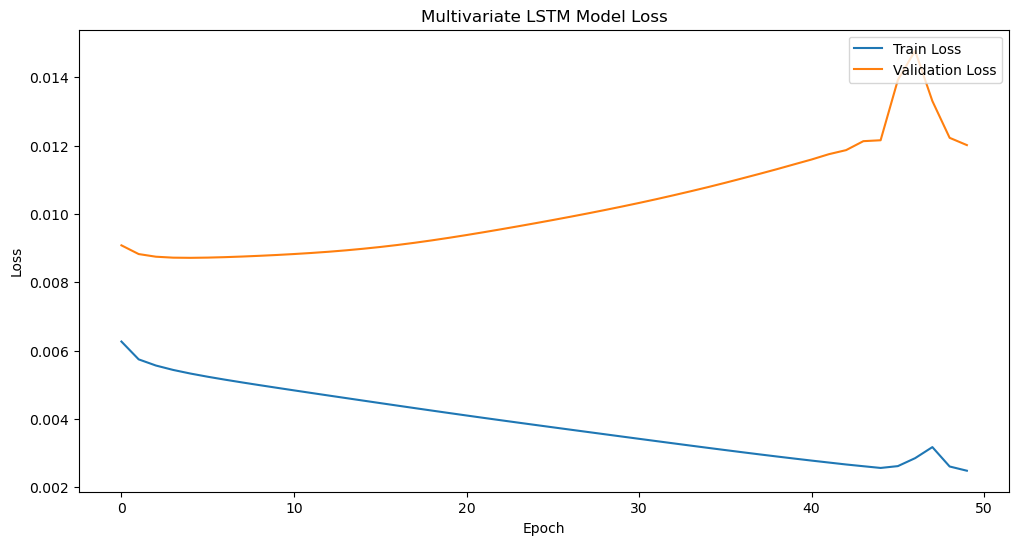

In [49]:
# Build the multivariate LSTM model
model_multi = Sequential()
model_multi.add(LSTM(50, input_shape=(trainX_multi.shape[1], trainX_multi.shape[2])))
model_multi.add(Dense(1))
model_multi.compile(loss='mean_squared_error', optimizer='adam')
# Train the multivariate LSTM model
history_multi = model_multi.fit(trainX_multi, trainY_multi, epochs=50, batch_size=32, validation_data=(testX_multi, testY_multi), verbose=2, shuffle=False)
# Plot training & validation loss values for multivariate LSTM
plt.figure(figsize=(12, 6))
plt.plot(history_multi.history['loss'], label='Train Loss')
plt.plot(history_multi.history['val_loss'], label='Validation Loss')
plt.title('Multivariate LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Epoch 1/100
75/75 - 0s - loss: 0.0023 - val_loss: 0.0122 - 194ms/epoch - 3ms/step
Epoch 2/100
75/75 - 0s - loss: 0.0023 - val_loss: 0.0124 - 160ms/epoch - 2ms/step
Epoch 3/100
75/75 - 0s - loss: 0.0023 - val_loss: 0.0125 - 162ms/epoch - 2ms/step
Epoch 4/100
75/75 - 0s - loss: 0.0022 - val_loss: 0.0127 - 189ms/epoch - 3ms/step
Epoch 5/100
75/75 - 0s - loss: 0.0022 - val_loss: 0.0128 - 164ms/epoch - 2ms/step
Epoch 6/100
75/75 - 0s - loss: 0.0022 - val_loss: 0.0129 - 169ms/epoch - 2ms/step
Epoch 7/100
75/75 - 0s - loss: 0.0021 - val_loss: 0.0130 - 181ms/epoch - 2ms/step
Epoch 8/100
75/75 - 0s - loss: 0.0021 - val_loss: 0.0132 - 179ms/epoch - 2ms/step
Epoch 9/100
75/75 - 0s - loss: 0.0021 - val_loss: 0.0131 - 180ms/epoch - 2ms/step
Epoch 10/100
75/75 - 0s - loss: 0.0020 - val_loss: 0.0135 - 177ms/epoch - 2ms/step
Epoch 11/100
75/75 - 0s - loss: 0.0020 - val_loss: 0.0133 - 181ms/epoch - 2ms/step
Epoch 12/100
75/75 - 0s - loss: 0.0020 - val_loss: 0.0137 - 197ms/epoch - 3ms/step
Epoch 13/100


Epoch 100/100
75/75 - 0s - loss: 9.5804e-04 - val_loss: 0.0156 - 211ms/epoch - 3ms/step
18/18 [==============================] - 0s 1ms/step


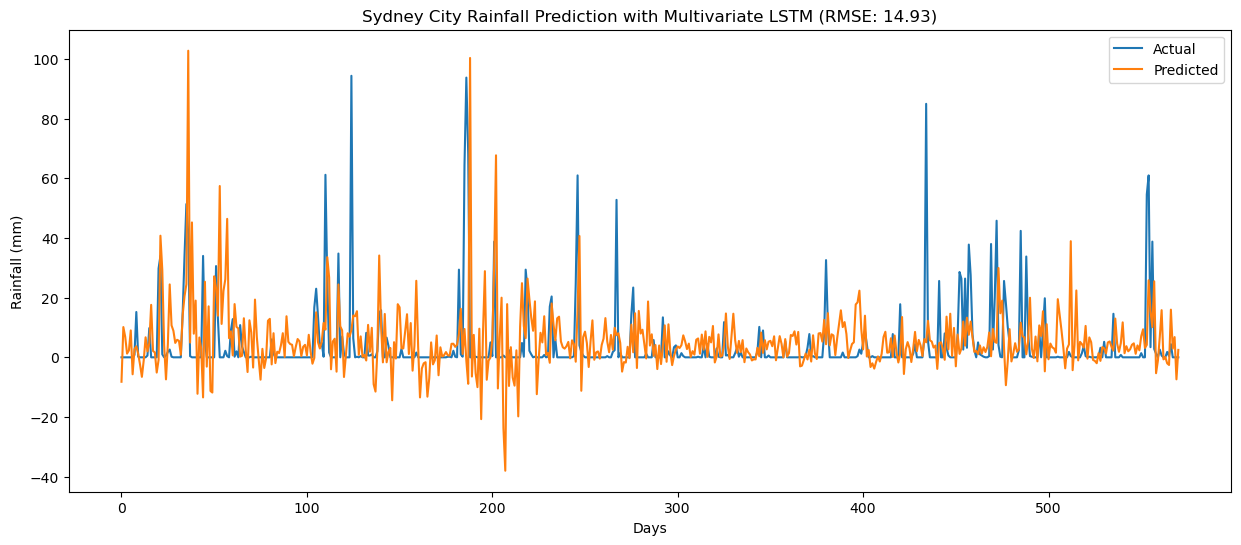

14.932116126039958

In [50]:
# Train the multivariate LSTM model with early stopping after 5 epochs
history_multi_early = model_multi.fit(trainX_multi, trainY_multi, epochs=100, batch_size=32, validation_data=(testX_multi, testY_multi), verbose=2, shuffle=False)
# Make predictions using the test data
test_predictions_multi = model_multi.predict(testX_multi)
# Inverse transform the predictions to original scale
test_predictions_multi = scaler_multi.inverse_transform(np.hstack([test_predictions_multi, np.zeros((test_predictions_multi.shape[0], multi_var_data.shape[1]-1))]))[:, 0]
# Inverse transform the actual test data to original scale
testY_multi_original = scaler_multi.inverse_transform(np.hstack([testY_multi.reshape(-1, 1), np.zeros((testY_multi.shape[0], multi_var_data.shape[1]-1))]))[:, 0]
# Calculate RMSE (Root Mean Squared Error)
rmse_multi = math.sqrt(mean_squared_error(testY_multi_original, test_predictions_multi))
# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(testY_multi_original, label='Actual')
plt.plot(test_predictions_multi, label='Predicted')
plt.title(f'Sydney City Rainfall Prediction with Multivariate LSTM (RMSE: {rmse_multi:.2f})')
plt.xlabel('Days')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()
# Display RMSE
rmse_multi

Epoch 1/100
75/75 - 2s - loss: 0.0069 - val_loss: 0.0095 - 2s/epoch - 28ms/step
Epoch 2/100
75/75 - 0s - loss: 0.0060 - val_loss: 0.0091 - 157ms/epoch - 2ms/step
Epoch 3/100
75/75 - 0s - loss: 0.0056 - val_loss: 0.0089 - 168ms/epoch - 2ms/step
Epoch 4/100
75/75 - 0s - loss: 0.0054 - val_loss: 0.0089 - 200ms/epoch - 3ms/step
Epoch 5/100
75/75 - 0s - loss: 0.0052 - val_loss: 0.0089 - 174ms/epoch - 2ms/step
Epoch 6/100
75/75 - 0s - loss: 0.0050 - val_loss: 0.0090 - 186ms/epoch - 2ms/step
Epoch 7/100
75/75 - 0s - loss: 0.0049 - val_loss: 0.0090 - 166ms/epoch - 2ms/step
Epoch 8/100
75/75 - 0s - loss: 0.0048 - val_loss: 0.0091 - 165ms/epoch - 2ms/step
Epoch 9/100
75/75 - 0s - loss: 0.0046 - val_loss: 0.0091 - 170ms/epoch - 2ms/step
Epoch 10/100
75/75 - 0s - loss: 0.0045 - val_loss: 0.0092 - 173ms/epoch - 2ms/step
Epoch 11/100
75/75 - 0s - loss: 0.0044 - val_loss: 0.0093 - 227ms/epoch - 3ms/step
Epoch 12/100
75/75 - 0s - loss: 0.0043 - val_loss: 0.0094 - 178ms/epoch - 2ms/step
Epoch 13/100
75

Epoch 100/100
75/75 - 0s - loss: 0.0017 - val_loss: 0.0169 - 172ms/epoch - 2ms/step
18/18 [==============================] - 0s 1000us/step


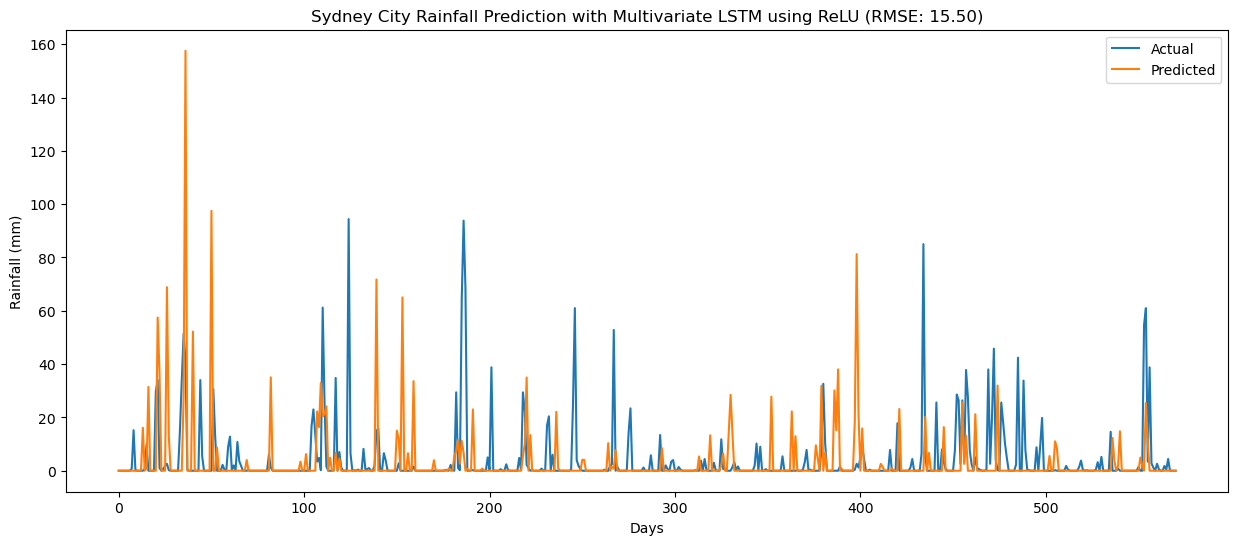

15.504411499486789

In [51]:
# Build the multivariate LSTM model with ReLU activation in the output layer
model_multi_relu = Sequential()
model_multi_relu.add(LSTM(50, input_shape=(trainX_multi.shape[1], trainX_multi.shape[2])))
model_multi_relu.add(Dense(1, activation='relu'))
model_multi_relu.compile(loss='mean_squared_error', optimizer='adam')
# Train the multivariate LSTM model with early stopping after 5 epochs
history_multi_relu = model_multi_relu.fit(trainX_multi, trainY_multi, epochs=100, batch_size=32, validation_data=(testX_multi, testY_multi), verbose=2, shuffle=False)
# Make predictions using the test data
test_predictions_multi_relu = model_multi_relu.predict(testX_multi)
# Inverse transform the predictions to original scale
test_predictions_multi_relu = scaler_multi.inverse_transform(np.hstack([test_predictions_multi_relu, np.zeros((test_predictions_multi_relu.shape[0], multi_var_data.shape[1]-1))]))[:, 0]
# Calculate RMSE (Root Mean Squared Error)
rmse_multi_relu = math.sqrt(mean_squared_error(testY_multi_original, test_predictions_multi_relu))
# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(testY_multi_original, label='Actual')
plt.plot(test_predictions_multi_relu, label='Predicted')
plt.title(f'Sydney City Rainfall Prediction with Multivariate LSTM using ReLU (RMSE: {rmse_multi_relu:.2f})')
plt.xlabel('Days')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()
# Display RMSE
rmse_multi_relu